<a href="https://colab.research.google.com/github/naomifridman/Introduction_to_deep_learning/blob/master/Deep_Learning_keras_lstm_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction to Deep Learning 
# RNN LSTM
### https://colah.github.io/posts/2015-08-Understanding-LSTMs/
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import utils_plot as uplot
import matplotlib.gridspec as gridspec
from sklearn.metrics import accuracy_score, log_loss

%matplotlib inline  

## Utilities

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score

def print_stats(ytest, ypred):
    
    print("Accuracy: {:.5f}, Cohen's Kappa Score: {:.5f}".format(
        accuracy_score(ytest, ypred), 
        cohen_kappa_score(ytest, ypred, weights="quadratic")))
    print("Confusion Matrix:")
    print(confusion_matrix(ytest, ypred))
    print("Classification Report:")
    print(classification_report(ytest, ypred))

In [0]:
def drow_history_list(history_list, history_names=None,  metric=None):
    
    if metric is None:
        metric = 'loss'
        
    leg = []
    if history_names is not None:
        for n in history_names:
            leg.append('train ' + n)
            leg.append('test ' + n)
    else:
        for n in range(len(history_list)):
            leg.append('train ' + str(n))
            leg.append('test ' + str(n))
            
    for hist in history_list:
        
        plt.plot(hist.history[metric])
        plt.plot(hist.history['val_'+ metric], '--', linewidth=2)
        
        
    plt.title('model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(leg, loc='best')
    plt.show()  

In [0]:
def drow_history(history, metric, i_start=0):
    if metric is None:
        metric = 'loss'
    plt.plot(history.history[metric][i_start:])
    plt.plot(history.history['val_'+ metric][i_start:])
    plt.title('model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()    

In [0]:
import keras
# Keras has many build in data sets
from keras.datasets import mnist
# Sequential is the basic feed forward neural network (FFN)
from keras.models import Sequential
# Dense is fully connected layer
# Dropout is a "noising" layer, to prevent over feet.
from keras.layers import Dense, Dropout
# Read about optimizers in keras documentation
from keras.optimizers import RMSprop
from keras import optimizers

In [0]:
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score

# Recurrent Neural Networks
Recurrent neural networks have loops in them, allowing information to persist, they have `memory`.
![title](rnn1.png)
RNN are the natural architecture to learn sequence, such as:
* Speech recognition, 
* language modeling,
* translation, 
* image captioning… 
> Recomended: http://karpathy.github.io/2015/05/21/rnn-effectiveness/

## The Problem of Long-Term Dependencies
One of the appeals of RNNs is the idea that they might be able to connect previous information to the present task, such as using previous video frames might inform the understanding of the present frame. If RNNs could do this, they’d be extremely useful. But can they? It depends.
* https://colah.github.io/posts/2015-08-Understanding-LSTMs/

## LSTM Networks
LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!

In [0]:
https://towardsdatascience.com/machine-learning-recurrent-neural-networks-and-long-short-term-memory-lstm-python-keras-example-86001ceaaebc

### Example
https://towardsdatascience.com/machine-learning-recurrent-neural-networks-and-long-short-term-memory-lstm-python-keras-example-86001ceaaebc


In the proceeding section, we go over my solution to a Kaggle competition whose goal it is to perform sentiment analysis on a corpus of movie reviews. We’re asked to label each phrase on a scale of zero to four. The sentiment corresponding to each of the labels are:
* 0: negative
* 1: somewhat negative
* 2: neutral
* 3: somewhat positive
* 4: positive

## Kaggle
https://www.kaggle.com/c/movie-review-sentiment-analysis-kernels-only/data

kaggle competitions download -c movie-review-sentiment-analysis-kernels-only

In [6]:
import os
os.environ['KAGGLE_USERNAME']='ripcurl' #xxxxxx
os.environ['KAGGLE_KEY']='fe6a30f9313cb9751139964b31c0f83b' #xxxxxx
!kaggle competitions download -c movie-review-sentiment-analysis-kernels-only

  0% 0.00/494k [00:00<?, ?B/s]
100% 494k/494k [00:00<00:00, 67.9MB/s]
  0% 0.00/583k [00:00<?, ?B/s]
100% 583k/583k [00:00<00:00, 79.9MB/s]
  0% 0.00/1.28M [00:00<?, ?B/s]
100% 1.28M/1.28M [00:00<00:00, 87.2MB/s]


In [7]:
!ls

sample_data  sampleSubmission.csv  test.tsv.zip  train.tsv.zip


In [8]:
!unzip train.tsv.zip

Archive:  train.tsv.zip
  inflating: train.tsv               


In [9]:
!unzip test.tsv.zip

Archive:  test.tsv.zip
  inflating: test.tsv                


In [10]:
!ls

sample_data	      test.tsv	    train.tsv
sampleSubmission.csv  test.tsv.zip  train.tsv.zip


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('dark_background')
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D

Using TensorFlow backend.


In [11]:
df_train = pd.read_csv('train.tsv', sep='\t')
print('train set: {0}'.format(df_train.shape))
df_train.head(10)

train set: (156060, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


In [0]:
test = pd.read_csv('boston_test.csv')
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [12]:
df_test = pd.read_csv('test.tsv', sep='\t')
print('test set: {0}'.format(df_test.shape))
df_test.head(10)

test set: (66292, 3)


,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
5,156066,8545,intermittently pleasing but
6,156067,8545,intermittently pleasing
7,156068,8545,intermittently
8,156069,8545,pleasing
9,156070,8545,but


In [0]:
replace_list = {r"i'm": 'i am',
                r"'re": ' are',
                r"let’s": 'let us',
                r"'s":  ' is',
                r"'ve": ' have',
                r"can't": 'can not',
                r"cannot": 'can not',
                r"shan’t": 'shall not',
                r"n't": ' not',
                r"'d": ' would',
                r"'ll": ' will',
                r"'scuse": 'excuse',
                ',': ' ,',
                '.': ' .',
                '!': ' !',
                '?': ' ?',
                '\s+': ' '}
def clean_text(text):
    text = text.lower()
    for s in replace_list:
        text = text.replace(s, replace_list[s])
    text = ' '.join(text.split())
    return text

In [0]:
X_train = df_train['Phrase'].apply(lambda p: clean_text(p))

In [0]:
X_test = df_test['Phrase'].apply(lambda p: clean_text(p))

max phrase len: 53


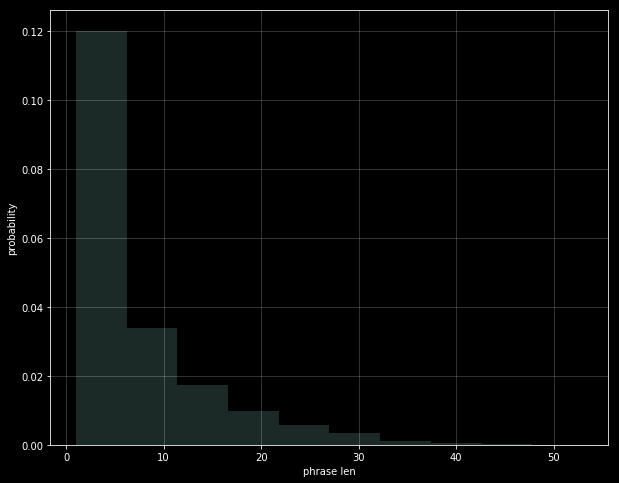

In [15]:
phrase_len = X_train.apply(lambda p: len(p.split(' ')))
max_phrase_len = phrase_len.max()
print('max phrase len: {0}'.format(max_phrase_len))
plt.figure(figsize = (10, 8))
plt.hist(phrase_len, alpha = 0.2, density = True)
plt.xlabel('phrase len')
plt.ylabel('probability')
plt.grid(alpha = 0.25)

In [0]:
y_train = df_train['Sentiment']

Computers don’t understand words, let alone sentences, therefore, we use the tokenizer to parse the phrases. In specifying num_words, only the most common num_words-1 words will be kept. We use a filter to remove special characters. By default, all punctuation is removed, turning the text into a space separated sequence of words. The tokens are then vectorized. By vectorized we mean that they are mapped to integers. 0 is a reserved index that won't be assigned to any word.
pad_sequence is used to ensure that all the phrase are the same length. Sequences that are shorter than maxlen are padded with value (0 by default) at the end.
Whenever we’re working with categorical data, we don’t want to leave it as integers because the model will interpreted the samples with a higher number as having more significance. to_categorical is quick and dirty way of encoding the data.

In [0]:
max_words = 8192
tokenizer = Tokenizer(
    num_words = max_words,
    filters = '"#$%&()*+-/:;<=>@[\]^_`{|}~'
)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen = max_phrase_len)
y_train = to_categorical(y_train)

In [0]:
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen = max_phrase_len)


## Build Keras model - train and predict

To understand the embeding layer, read:
* https://towardsdatascience.com/machine-learning-sentiment-analysis-and-word-embeddings-python-keras-example-4dfb93c5a6cf?source=post_page-----86001ceaaebc----------------------

In [20]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim = max_words, output_dim = 256, input_length = max_phrase_len))
model_lstm.add(SpatialDropout1D(0.3))
model_lstm.add(LSTM(256, dropout = 0.3, recurrent_dropout = 0.3))
model_lstm.add(Dense(256, activation = 'relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(5, activation = 'softmax'))
model_lstm.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [21]:
history = model_lstm.fit(
    X_train,
    y_train,
    validation_split = 0.1,
    epochs = 8,
    batch_size = 512
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 140454 samples, validate on 15606 samples
Epoch 1/8
140454/140454 [==============================] - 59s 423us/step - loss: 1.0700 - acc: 0.5733 - val_loss: 1.0210 - val_acc: 0.5882
Epoch 2/8
140454/140454 [==============================] - 54s 385us/step - loss: 0.8558 - acc: 0.6562 - val_loss: 0.9929 - val_acc: 0.6071
Epoch 3/8
140454/140454 [==============================] - 54s 385us/step - loss: 0.8031 - acc: 0.6764 - val_loss: 0.9985 - val_acc: 0.6071
Epoch 4/8
140454/140454 [==============================] - 54s 385us/step - loss: 0.7694 - acc: 0.6870 - val_loss: 1.0166 - val_acc: 0.6044
Epoch 5/8
140454/140454 [==============================] - 54s 385us/step - loss: 0.7446 - acc: 0.6969 - val_loss: 1.0291 - val_acc: 0.6083
Epoch 6/8
140454/140454 [==============================] - 54s 387us/step - loss: 0.7233 - acc: 0.7035 - val_loss: 1.0387 - val_acc: 0.6035
Epoch 7/8
14045

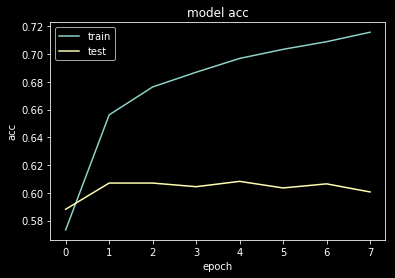

In [27]:
drow_history(history,'acc')

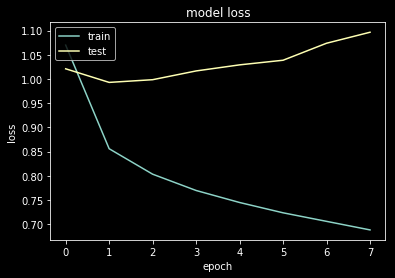

In [28]:
drow_history(history,'loss')

In [40]:
X_train.shape, X_test.shape

((156060, 53), (66292, 53))

In [0]:
pred = model_lstm.predict_classes(X_test)


In [42]:
df_test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [43]:

df_test['Sentiment'] = predictions
df_test[['Sentiment']].to_csv("submission.csv", index=False)

NameError: ignored

In [0]:
from google.colab import files
files.download('submission.csv')